In [1]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# ===============================
# 2. LOAD THE DATASET
# ===============================
# Change this file name to match your CSV name
DATA_PATH = "spam_Emails_data.csv"  # e.g. "spam_ham_dataset.csv"

# Read CSV
df = pd.read_csv(DATA_PATH)

print("First 5 rows of dataset:")
print(df.head())
print("\nColumns in dataset:", df.columns.tolist())

# ===============================
# 3. SET TEXT & LABEL COLUMNS
# ===============================
# >>> IMPORTANT <<<
# Change these names according to your dataset.
# For example, if your columns are 'text' and 'label', use that.

# Try common names (you can adjust if needed)
POSSIBLE_TEXT_COLS = ["text", "message", "Email Text", "email"]
POSSIBLE_LABEL_COLS = ["label", "Category", "spam_or_ham", "target"]

text_col = None
label_col = None

for c in df.columns:
    if c in POSSIBLE_TEXT_COLS:
        text_col = c
    if c in POSSIBLE_LABEL_COLS:
        label_col = c

# If automatic detection failed, set manually like:
# text_col = "text"
# label_col = "label"

print("\nDetected text column:", text_col)
print("Detected label column:", label_col)

if text_col is None or label_col is None:
    raise ValueError("Could not auto-detect text/label columns. Please set text_col and label_col manually.")

# ===============================
# 4. BASIC CLEANING
# ===============================
# Drop rows where text is missing
df = df.dropna(subset=[text_col, label_col])

# If labels are like 'ham'/'spam', keep as is.
# If they are 0/1, we are also fine.
print("\nLabel value counts:")
print(df[label_col].value_counts())

# ===============================
# 5. TRAIN-TEST SPLIT
# ===============================
X = df[text_col]   # features: raw email text
y = df[label_col]  # target: ham/spam

# 80% training, 20% testing (you can change test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps spam/ham ratio same in train & test
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# ===============================
# 6. BUILD TF-IDF + LOGISTIC REGRESSION PIPELINE
# ===============================
# TfidfVectorizer turns text into numeric vectors
# LogisticRegression is a strong baseline classifier for text.

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        max_df=0.95,   # ignore super common words
        min_df=5,      # ignore very rare words
        ngram_range=(1, 2)  # unigrams + bigrams
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

# ===============================
# 7. TRAIN THE MODEL
# ===============================
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Training complete!")

# ===============================
# 8. EVALUATE THE MODEL
# ===============================
print("\nEvaluating on test set...")
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ===============================
# 9. SAVE THE MODEL FOR LATER USE
# ===============================
MODEL_PATH = "spam_classifier_tfidf_logreg.joblib"
joblib.dump(model, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")

# ===============================
# 10. TEST ON CUSTOM EMAILS
# ===============================
sample_emails = [
    "Congratulations! You have won a $1000 Walmart gift card. Click here to claim.",
    "Hey, can we reschedule our meeting to tomorrow afternoon?",
    "You have an overdue payment. Please login to your bank account with the link below."
]

sample_preds = model.predict(sample_emails)

print("\nSample predictions:")
for email, pred in zip(sample_emails, sample_preds):
    print(f"Text: {email}\nPredicted label: {pred}\n")


First 5 rows of dataset:
  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...

Columns in dataset: ['label', 'text']

Detected text column: text
Detected label column: label

Label value counts:
label
Ham     35518
Spam    32161
Name: count, dtype: int64

Train size: 54143, Test size: 13536

Training the model...
Training complete!

Evaluating on test set...

Accuracy: 0.9743

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98      7104
        Spam       0.96      0.98      0.97      6432

    accuracy                           0.97     13536
   macro avg       0.97      0.97      0.97     13536
weighted avg       0.97 

<Figure size 600x500 with 0 Axes>

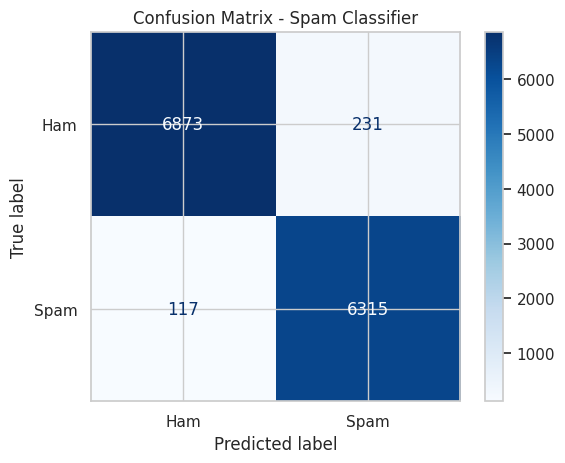

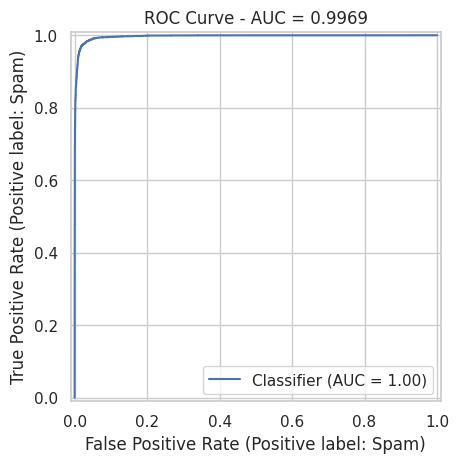

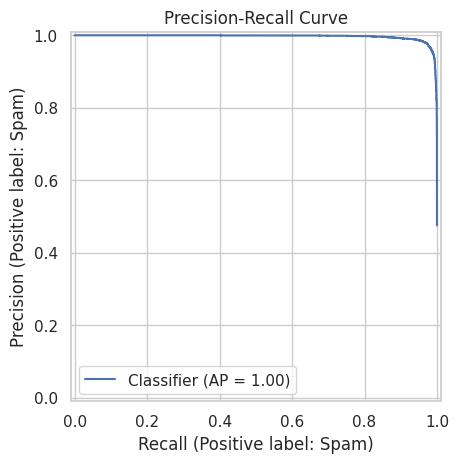

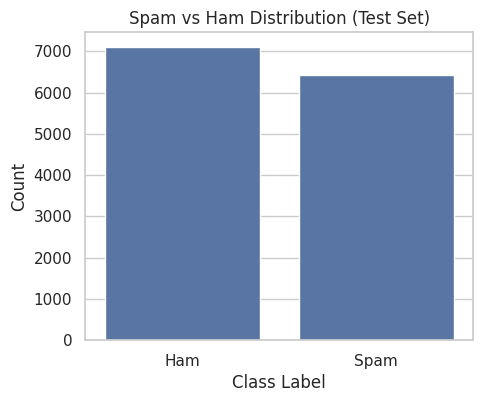


Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98      7104
        Spam       0.96      0.98      0.97      6432

    accuracy                           0.97     13536
   macro avg       0.97      0.97      0.97     13536
weighted avg       0.97      0.97      0.97     13536



In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_auc_score,
    classification_report
)
import seaborn as sns

sns.set(style="whitegrid")

# Detect exact spam label (case insensitive)
classes = list(model.classes_)
spam_label = next(c for c in classes if c.lower() == "spam")
spam_index = classes.index(spam_label)

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix - Spam Classifier")
plt.show()

# =========================
# ROC CURVE + AUC
# =========================
y_probs = model.predict_proba(X_test)[:, spam_index]

RocCurveDisplay.from_predictions(y_test, y_probs, pos_label=spam_label)
auc = roc_auc_score(y_test, y_probs)
plt.title(f"ROC Curve - AUC = {auc:.4f}")
plt.show()

# =========================
# PRECISION-RECALL CURVE
# =========================
PrecisionRecallDisplay.from_predictions(y_test, y_probs, pos_label=spam_label)
plt.title("Precision-Recall Curve")
plt.show()

# =========================
# CLASS DISTRIBUTION
# =========================
plt.figure(figsize=(5, 4))
sns.countplot(x=y_test)
plt.title("Spam vs Ham Distribution (Test Set)")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

# =========================
# CLASSIFICATION REPORT
# =========================
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
